<a href="https://colab.research.google.com/github/scardenol/ai_2023/blob/main/4.%20Supervised%202/entrega_Salo/src/supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from math import comb # for combinations
import itertools

# Import the models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

# Import cross-validation score
from sklearn.model_selection import cross_val_score

## Define plot function with plotly

In [2]:
# 2D and 3D scatter plots with plotly
def plotly_scatter(df, names, plot_type="2D", color=None, template=None,
                   title=None, color_discrete_sequence=None, opacity=1,
                   legend_params=dict(yanchor="bottom",
                                      y=0.01,
                                      xanchor="left",
                                      x=0.01),
                   title_params=dict(
                      x=0.5,
                      y=0.85)
                   ):
    """ Create a 2D or 3D scatter plot with plotly.
    
    Args:
        df (pd.DataFrame): the data to be plotted.
        names (list): the list of feature names.
        plot_type (str): the type of plot, must be "2D" or "3D".
        color (str): the name of the column to be used as color.
        title (str): the title of the plot.
        color_discrete_sequence (list): the list of colors to be used.
        opacity (float): the opacity of the points.
        
    Returns:
        None
    """
    if color_discrete_sequence == None:
        color_discrete_sequence = [*list(range(len(df.iloc[:,-1].unique())-1)),"black"]
    if plot_type=="2D":
      fig = px.scatter(data_frame=df, x=names[0], y=names[1], color=color,
                       title=title, color_discrete_sequence=color_discrete_sequence,
                       template=template)
    elif plot_type=="3D":
      fig = px.scatter_3d(data_frame=df, x=names[0], y=names[1], z=names[2],
                          color=color, title=title, color_discrete_sequence=color_discrete_sequence,
                          template=template)
    else:
        raise ValueError("Invalid plot_type muste be ""2D"" or ""3D"".")
    fig.update_traces(opacity=opacity)
    fig.update_layout(autosize=False, width=700, height=700,
                      legend=legend_params,
                      title=title_params,
                      )
    fig.show()

# Original data space

## Load data

In [3]:
# Load and read data set
url = "https://github.com/scardenol/ai_2023/blob/main/4.%20Supervised%202/entrega_Salo/data/clustered_data.csv?raw=true"
data = pd.read_csv(url, index_col=0)

In [4]:
# Preview dataframe
data

,Age,Annual Income (k$),Spending Score (1-100),cluster
0,0.961538,0.270492,0.479592,cluster 0
1,0.576923,0.368852,0.489796,cluster 0
2,0.961538,0.360656,0.551020,cluster 0
3,0.615385,0.352459,0.459184,cluster 0
4,0.307692,0.516393,0.000000,cluster 0
...,...,...,...,...
195,0.153846,0.319672,0.540816,cluster 1
196,0.269231,0.270492,0.469388,cluster 1
197,0.019231,0.270492,0.591837,cluster 1
198,0.153846,0.385246,0.551020,cluster 1


In [5]:
# Remap cluster column
target_map = {"cluster 0":0, "cluster 1":1}
data['cluster'] = data['cluster'].map(target_map)

In [6]:
# Take cluster column as categorical
data['cluster'] = data['cluster'].astype('category')

## Visualize the data

In [7]:
# Visualize labeled data in 3D

fig = plotly_scatter(data,
                     names=data.columns,
                     plot_type="3D",
                     color="cluster",
                     color_discrete_sequence=['#636EFA', '#EF553B'],
                     title="Original data space",
                     opacity=0.7,
                     template="plotly",
                     legend_params=dict(yanchor="bottom",y=0.01,
                                        xanchor="left",x=0.01),
                     title_params=dict(x=0.5, y=0.85)
                     )

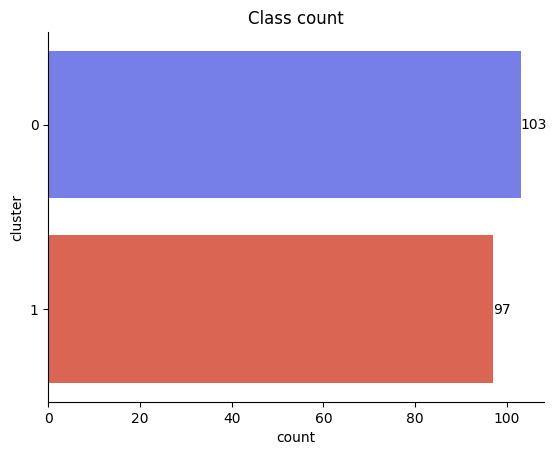

In [8]:
# Set custom color palette for seaborn to match the palette from plotly
my_color_palette = ['#636EFA', '#EF553B']
sns.set_palette(palette=my_color_palette)

# Barplot of class distribution
ax = sns.countplot(data, y="cluster", orient = "h", );

# Remove top and right borders
sns.despine()

# Add number on top of bar
for container in ax.containers:
    ax.bar_label(container)

# Set title
ax.set(title="Class count");

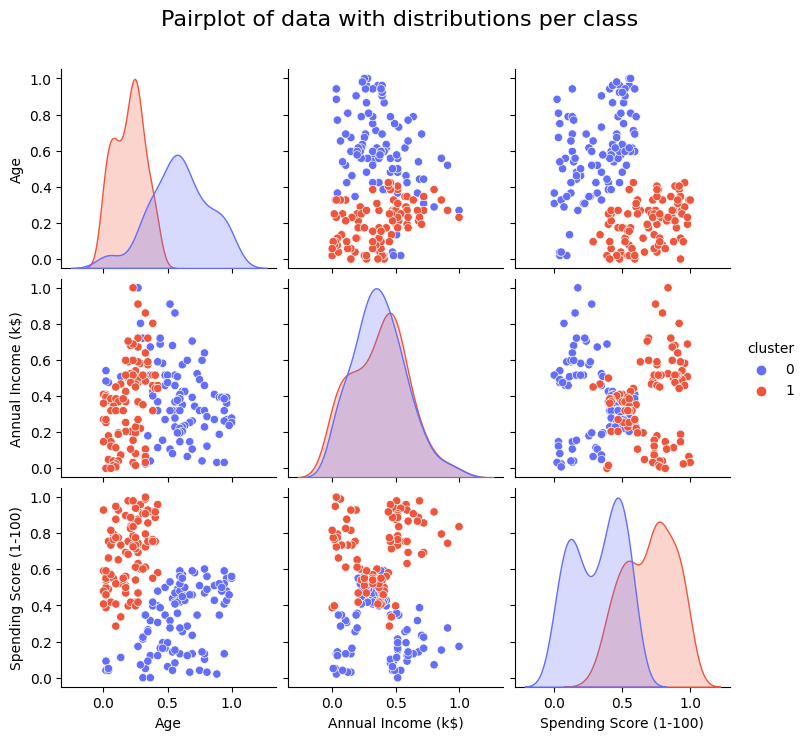

In [9]:
# Distribution of features
ax = sns.pairplot(data, hue="cluster");
ax.fig.suptitle("Pairplot of data with distributions per class", size=16);
ax.figure.subplots_adjust(top=.9)

## Split data into train, validation and test

Because there are only 200 data observations, it would be wiser to split the data into train and test, and use the train set to fit (train) the model and also to perform cross-validation (https://scikit-learn.org/stable/modules/cross_validation.html).

In [10]:
# Set random seed for reproducibility
seed = 0
np.random.seed(seed)

In [11]:
# Split the data in 50:50 for train:test dataset
train_size = 0.5

X = data.drop(columns = ['cluster']).copy()
y = data['cluster']

# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=seed)

# Print resulting shapes
print(f"Train shape: features = {X_train.shape}, target = {y_train.shape}")
print(f"Test shape: features = {X_test.shape}, target = {y_test.shape}")

Train shape: features = (100, 3), target = (100,)
Test shape: features = (100, 3), target = (100,)


## Train models and compute training, average cross-validation and testing errors


### Train the models

In [12]:
# Instantiate the models
dt = DecisionTreeClassifier()
svm_linear = SVC(kernel = 'linear')
svm_poly = SVC(kernel = 'poly')
svm_rbf = SVC(kernel = 'rbf')
lr = LinearRegression()
logr = LogisticRegression()

In [13]:
# Store models in a list
models = [dt, svm_linear, svm_poly, svm_rbf, lr, logr]

In [14]:
# Variable to store results
results = []
for model in models:
  # Fit (train) the model with train data
  model.fit(X_train, y_train)

  # Create dictionary with results
  errors = {
      "training_error":1-model.score(X_train, y_train),
      "avg_crossvalidation_error":1-np.mean(cross_val_score(model, X_train, y_train, cv=5)),
      "testing_error":1-model.score(X_test, y_test),
  }

  # Print
  print(f"----------------{model}----------------")
  for key, value in errors.items():
    print(f"{key} = {value}")

  model_name = str(model)
  results.append({model_name:model, model_name+"_errors":errors})

----------------DecisionTreeClassifier()----------------
training_error = 0.0
avg_crossvalidation_error = 0.040000000000000036
testing_error = 0.050000000000000044
----------------SVC(kernel='linear')----------------
training_error = 0.030000000000000027
avg_crossvalidation_error = 0.029999999999999916
testing_error = 0.06999999999999995
----------------SVC(kernel='poly')----------------
training_error = 0.0
avg_crossvalidation_error = 0.019999999999999907
testing_error = 0.010000000000000009
----------------SVC()----------------
training_error = 0.0
avg_crossvalidation_error = 0.010000000000000009
testing_error = 0.020000000000000018
----------------LinearRegression()----------------
training_error = 0.19506223664319444
avg_crossvalidation_error = 0.205333828449336
testing_error = 0.24123984394674824
----------------LogisticRegression()----------------
training_error = 0.030000000000000027
avg_crossvalidation_error = 0.029999999999999916
testing_error = 0.050000000000000044


### Find the min number of samples to train the models

In [15]:
def get_required_samples(vc: float, epsilon: float, delta: float) -> int:
  """
  This function computes the sample complexity bound "n" in the Probably
  Approximated Correct learning guarantee (PAC) learning framework. It provides
  an estimation of the minimum number of training examples "n" required to achieve
  a desired level of generalization:
  n ≥ 1/ε (ln |H| + ln 1/δ )
  or if we know the VC dimension then
  n ≥ 1/ε (vc + ln 1/δ ).
  Where n is the number of required samples, epsilon "ε" is the maximum allowed
  generalization error, vc is the VC dimension of the hypothesis class, i.e., a
  measure of the capacity or complexity of the hypothesis class and represents
  the maximum number of points that can be shattered (correctly classified) by
  any set of points, and delta "δ" is the significance level or the acceptable
  probability of the true error exciding "ε".
  The true error ≥ ε and the training error ≥ 0. Also, 1 ≥ 0 δ > 0.
  Args:
        vc (_float_): the vc dimension for an specific learner (aka model, estimator).
        epsilon (_float_): the maximum allowed generalization error.
        delta (_float_): the acceptable probability that the true error exceeds
        epsilon.
  Returns:
        _int_: the estimated sample complexity bound, or the number of samples
        required to achieve the desired level of generalization.
  """
  return np.ceil(1/epsilon * (vc + np.log(1/delta)))

def vc_dimension(model, features):
  d = features.shape[1]
  models_name = str(model)
  vc = None

  if any(models_name in x for x in ['LogisticRegression()',
                                    'LinearRegression()',
                                    'SVC(kernel=\'linear\')']):
    vc = d + 1

  elif models_name in 'DecisionTreeClassifier()':
    n = model.tree_.node_count
    vc = n * np.log(n*d)

  elif models_name in 'SVC(kernel=\'poly\')':
    p = model.degree
    vc = comb(d + p - 1, p)

  elif models_name in 'SVC()':
    vc = np.inf

  return vc

#def get_params_number(model):
#  models_name = get_models_name(model)
#
#  if models_name in ['LogisticRegression', 'lin', 'logistic']:
#    num_parameters = len(model.coef_[0])
#
#  elif models_name in ['DecisionTreeClassifier', 'trees', 'tree']:
#    num_parameters = model.tree_.node_count
#  
#  elif models_name in 'LinearSVC':
#    num_parameters = sum(model.coef_.shape[1] for coef in model.coef_)
#  elif models_name in ['poly', 'PolySVC', 'rbf', 'RbfSVC']:
#    num_parameters = sum(model.n_support_)
#
#  return num_parameters


In [16]:
# Create empty dataframe with columns
pac_data = pd.DataFrame(columns = ["model", "vc", "n", "epsilon", "delta"])

# Possible values for epsilon and delta
epsilons = [0.1, 0.05, 0.01]
deltas = epsilons

# Number of required samples
for (model, (epsilon, delta)) in itertools.product(models,zip(epsilons, deltas)):
  vc = vc_dimension(model, X_train)
  n = get_required_samples(vc, epsilon=epsilon, delta=delta)
  pac_data = pac_data.append({"model":model, "vc":vc, "n":n,
                              "epsilon":epsilon, "delta":delta},
                             ignore_index=True)
  print(f"model = {model}, vc = {vc}, n = {n}")

model = DecisionTreeClassifier(), vc = 38.461583176131285, n = 408.0
model = DecisionTreeClassifier(), vc = 38.461583176131285, n = 830.0
model = DecisionTreeClassifier(), vc = 38.461583176131285, n = 4307.0
model = SVC(kernel='linear'), vc = 4, n = 64.0
model = SVC(kernel='linear'), vc = 4, n = 140.0
model = SVC(kernel='linear'), vc = 4, n = 861.0
model = SVC(kernel='poly'), vc = 10, n = 124.0
model = SVC(kernel='poly'), vc = 10, n = 260.0
model = SVC(kernel='poly'), vc = 10, n = 1461.0
model = SVC(), vc = inf, n = inf
model = SVC(), vc = inf, n = inf
model = SVC(), vc = inf, n = inf
model = LinearRegression(), vc = 4, n = 64.0
model = LinearRegression(), vc = 4, n = 140.0
model = LinearRegression(), vc = 4, n = 861.0
model = LogisticRegression(), vc = 4, n = 64.0
model = LogisticRegression(), vc = 4, n = 140.0
model = LogisticRegression(), vc = 4, n = 861.0


In [17]:
pac_data

,model,vc,n,epsilon,delta
0,DecisionTreeClassifier(),38.461583,408.0,0.10,0.10
1,DecisionTreeClassifier(),38.461583,830.0,0.05,0.05
2,DecisionTreeClassifier(),38.461583,4307.0,0.01,0.01
3,SVC(kernel='linear'),4.000000,64.0,0.10,0.10
4,SVC(kernel='linear'),4.000000,140.0,0.05,0.05
5,SVC(kernel='linear'),4.000000,861.0,0.01,0.01
6,SVC(kernel='poly'),10.000000,124.0,0.10,0.10
7,SVC(kernel='poly'),10.000000,260.0,0.05,0.05
8,SVC(kernel='poly'),10.000000,1461.0,0.01,0.01
9,SVC(),inf,inf,0.10,0.10


# Embedded space with UMAP

## Load data

In [18]:
# Load and read data set
url2 = "https://github.com/scardenol/ai_2023/blob/main/4.%20Supervised%202/entrega_Salo/data/clustered_data_umap.csv?raw=true"
data_umap = pd.read_csv(url2, index_col=0)

In [19]:
# Preview dataframe
data_umap

,x,y,cluster
0,0.578468,0.409441,cluster 0
1,0.395837,0.146222,cluster 0
2,0.580768,0.531765,cluster 0
3,0.733679,0.049064,cluster 0
4,0.431522,0.440828,cluster 0
...,...,...,...
195,0.015726,0.693650,cluster 1
196,0.028872,0.671127,cluster 1
197,0.523248,0.896720,cluster 1
198,0.034931,0.659698,cluster 1


In [20]:
# Remap cluster column
target_map = {"cluster 0":0, "cluster 1":1}
data_umap['cluster'] = data_umap['cluster'].map(target_map)

In [21]:
# Take cluster column as categorical
data_umap['cluster'] = data_umap['cluster'].astype('category')

## Visualize the data

In [22]:
# Visualize labeled data in 2D

fig2 = plotly_scatter(data_umap,
                     names=data_umap.columns,
                     plot_type="2D",
                     color="cluster",
                     color_discrete_sequence=['#636EFA', '#EF553B'],
                     title="Embedded data space with UMAP",
                     opacity=0.7,
                     template="plotly",
                     legend_params=dict(yanchor="top",y=0.99,
                                        xanchor="right",x=0.99),
                     title_params=dict(x=0.5, y=0.9)
                     )

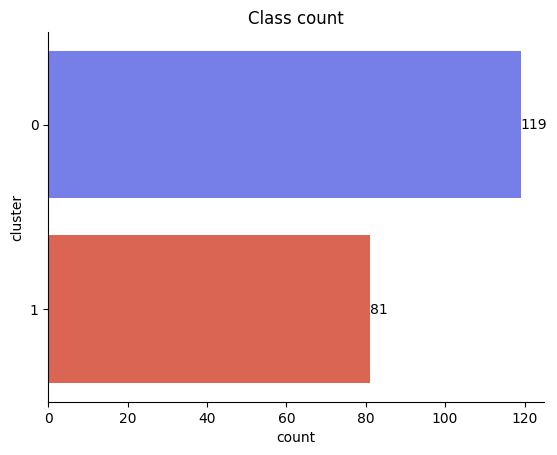

In [23]:
# Set custom color palette for seaborn to match the palette from plotly
my_color_palette = ['#636EFA', '#EF553B']
sns.set_palette(palette=my_color_palette)

# Barplot of class distribution
ax = sns.countplot(data_umap, y="cluster", orient = "h", );

# Remove top and right borders
sns.despine()

# Add number on top of bar
for container in ax.containers:
    ax.bar_label(container)

# Set title
ax.set(title="Class count");

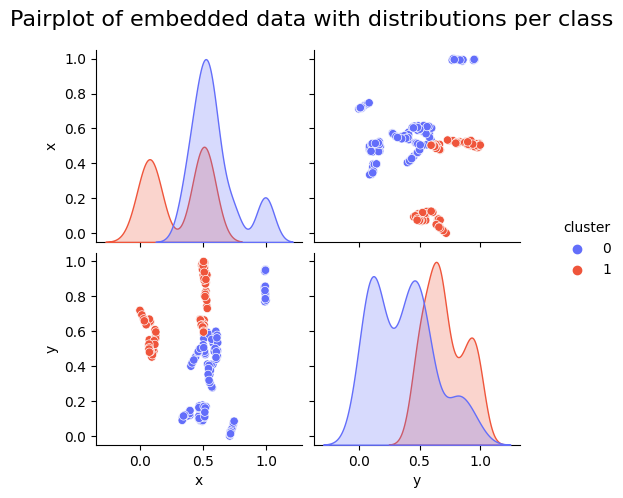

In [24]:
# Distribution of features
ax = sns.pairplot(data_umap, hue="cluster");
ax.fig.suptitle("Pairplot of embedded data with distributions per class", size=16);
ax.figure.subplots_adjust(top=.9)

## Split data into train, validation and test

Because there are only 200 data observations, it would be wiser to split the data into train and test, and use the train set to fit (train) the model and also to perform cross-validation (https://scikit-learn.org/stable/modules/cross_validation.html).

In [25]:
# Set random seed for reproducibility
seed = 0
np.random.seed(seed)

In [26]:
# Split the data in 50:50 for train:test dataset
train_size = 0.5

X = data_umap.drop(columns = ['cluster']).copy()
y = data_umap['cluster']

# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=seed)

# Print resulting shapes
print(f"Train shape: features = {X_train.shape}, target = {y_train.shape}")
print(f"Test shape: features = {X_test.shape}, target = {y_test.shape}")

Train shape: features = (100, 2), target = (100,)
Test shape: features = (100, 2), target = (100,)


## Train models and compute training, average cross-validation and testing errors

### Train the models

In [27]:
# Instantiate the models
dt = DecisionTreeClassifier()
svm_linear = SVC(kernel = 'linear')
svm_poly = SVC(kernel = 'poly')
svm_rbf = SVC(kernel = 'rbf')
lr = LinearRegression()
logr = LogisticRegression()

In [28]:
# Store models in a list
models = [dt, svm_linear, svm_poly, svm_rbf, lr, logr]

In [29]:
# Variable to store results
results = []
for model in models:
  # Fit (train) the model with train data
  model.fit(X_train, y_train)

  # Create dictionary with results
  errors = {
      "training_error":1-model.score(X_train, y_train),
      "avg_crossvalidation_error":1-np.mean(cross_val_score(model, X_train, y_train, cv=5)),
      "testing_error":1-model.score(X_test, y_test),
  }

  # Print
  print(f"----------------{model}----------------")
  for key, value in errors.items():
    print(f"{key} = {value}")

  model_name = str(model)
  results.append({model_name:model, model_name+"_errors":errors})

----------------DecisionTreeClassifier()----------------
training_error = 0.0
avg_crossvalidation_error = 0.019999999999999907
testing_error = 0.020000000000000018
----------------SVC(kernel='linear')----------------
training_error = 0.07999999999999996
avg_crossvalidation_error = 0.07000000000000006
testing_error = 0.010000000000000009
----------------SVC(kernel='poly')----------------
training_error = 0.0
avg_crossvalidation_error = 0.0
testing_error = 0.0
----------------SVC()----------------
training_error = 0.0
avg_crossvalidation_error = 0.0
testing_error = 0.0
----------------LinearRegression()----------------
training_error = 0.3033855272816999
avg_crossvalidation_error = 0.31893929357212636
testing_error = 0.2220656191954271
----------------LogisticRegression()----------------
training_error = 0.10999999999999999
avg_crossvalidation_error = 0.11999999999999988
testing_error = 0.020000000000000018


### Find the min number of samples to train the models

In [30]:
# Create empty dataframe with columns
pac_data_umap = pd.DataFrame(columns = ["model", "vc", "n", "epsilon", "delta"])

# Possible values for epsilon and delta
epsilons = [0.1, 0.05, 0.01]
deltas = epsilons

# Number of required samples
for (model, (epsilon, delta)) in itertools.product(models,zip(epsilons, deltas)):
  vc = vc_dimension(model, X_train)
  n = get_required_samples(vc, epsilon=epsilon, delta=delta)
  pac_data_umap = pac_data_umap.append({"model":model, "vc":vc, "n":n,
                              "epsilon":epsilon, "delta":delta},
                             ignore_index=True)
  print(f"model = {model}, vc = {vc}, n = {n}")

model = DecisionTreeClassifier(), vc = 26.01334582106548, n = 284.0
model = DecisionTreeClassifier(), vc = 26.01334582106548, n = 581.0
model = DecisionTreeClassifier(), vc = 26.01334582106548, n = 3062.0
model = SVC(kernel='linear'), vc = 3, n = 54.0
model = SVC(kernel='linear'), vc = 3, n = 120.0
model = SVC(kernel='linear'), vc = 3, n = 761.0
model = SVC(kernel='poly'), vc = 4, n = 64.0
model = SVC(kernel='poly'), vc = 4, n = 140.0
model = SVC(kernel='poly'), vc = 4, n = 861.0
model = SVC(), vc = inf, n = inf
model = SVC(), vc = inf, n = inf
model = SVC(), vc = inf, n = inf
model = LinearRegression(), vc = 3, n = 54.0
model = LinearRegression(), vc = 3, n = 120.0
model = LinearRegression(), vc = 3, n = 761.0
model = LogisticRegression(), vc = 3, n = 54.0
model = LogisticRegression(), vc = 3, n = 120.0
model = LogisticRegression(), vc = 3, n = 761.0


In [31]:
pac_data_umap

,model,vc,n,epsilon,delta
0,DecisionTreeClassifier(),26.013346,284.0,0.10,0.10
1,DecisionTreeClassifier(),26.013346,581.0,0.05,0.05
2,DecisionTreeClassifier(),26.013346,3062.0,0.01,0.01
3,SVC(kernel='linear'),3.000000,54.0,0.10,0.10
4,SVC(kernel='linear'),3.000000,120.0,0.05,0.05
5,SVC(kernel='linear'),3.000000,761.0,0.01,0.01
6,SVC(kernel='poly'),4.000000,64.0,0.10,0.10
7,SVC(kernel='poly'),4.000000,140.0,0.05,0.05
8,SVC(kernel='poly'),4.000000,861.0,0.01,0.01
9,SVC(),inf,inf,0.10,0.10


# Autoencoded space

## Load data

In [32]:
# Load and read data set
url3 = "https://github.com/scardenol/ai_2023/blob/main/4.%20Supervised%202/entrega_Salo/data/clustered_data_autoencoder.csv?raw=true"
data_autoencoded = pd.read_csv(url3, index_col=0)

In [33]:
# Preview dataframe
data_autoencoded

,x1,x2,x3,x4,x5,cluster
0,0.814855,0.282589,0.179327,0.321714,0.397662,cluster 0
1,0.668109,0.711973,0.268991,0.364293,0.369320,cluster 0
2,0.579681,0.642166,0.362813,0.429637,0.430217,cluster 0
3,0.478500,0.538928,0.413032,0.630015,0.663007,cluster 0
4,0.524284,0.620013,0.466745,0.368641,0.336845,cluster 0
...,...,...,...,...,...,...
195,0.233387,0.409281,0.902806,0.266630,0.132695,cluster 1
196,0.354465,0.441757,0.694732,0.400361,0.336883,cluster 1
197,0.459351,0.351165,0.639844,0.271962,0.216366,cluster 1
198,0.260173,0.119756,0.846576,0.429563,0.369031,cluster 1


In [34]:
# Remap cluster column
target_map = {"cluster 0":0, "cluster 1":1}
data_autoencoded['cluster'] = data_autoencoded['cluster'].map(target_map)

In [35]:
# Take cluster column as categorical
data_autoencoded['cluster'] = data_autoencoded['cluster'].astype('category')

## Visualize the data

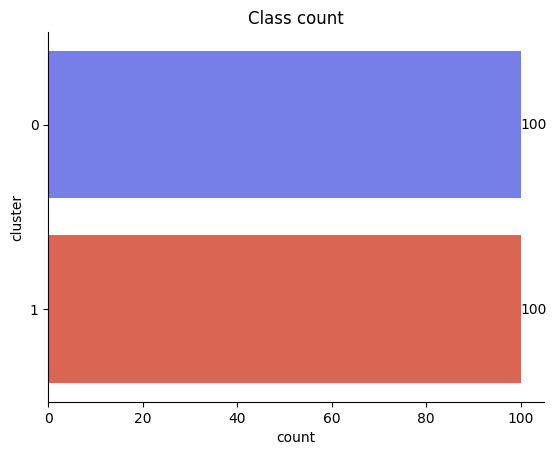

In [36]:
# Set custom color palette for seaborn to match the palette from plotly
my_color_palette = ['#636EFA', '#EF553B']
sns.set_palette(palette=my_color_palette)

# Barplot of class distribution
ax = sns.countplot(data_autoencoded, y="cluster", orient = "h", );

# Remove top and right borders
sns.despine()

# Add number on top of bar
for container in ax.containers:
    ax.bar_label(container)

# Set title
ax.set(title="Class count");

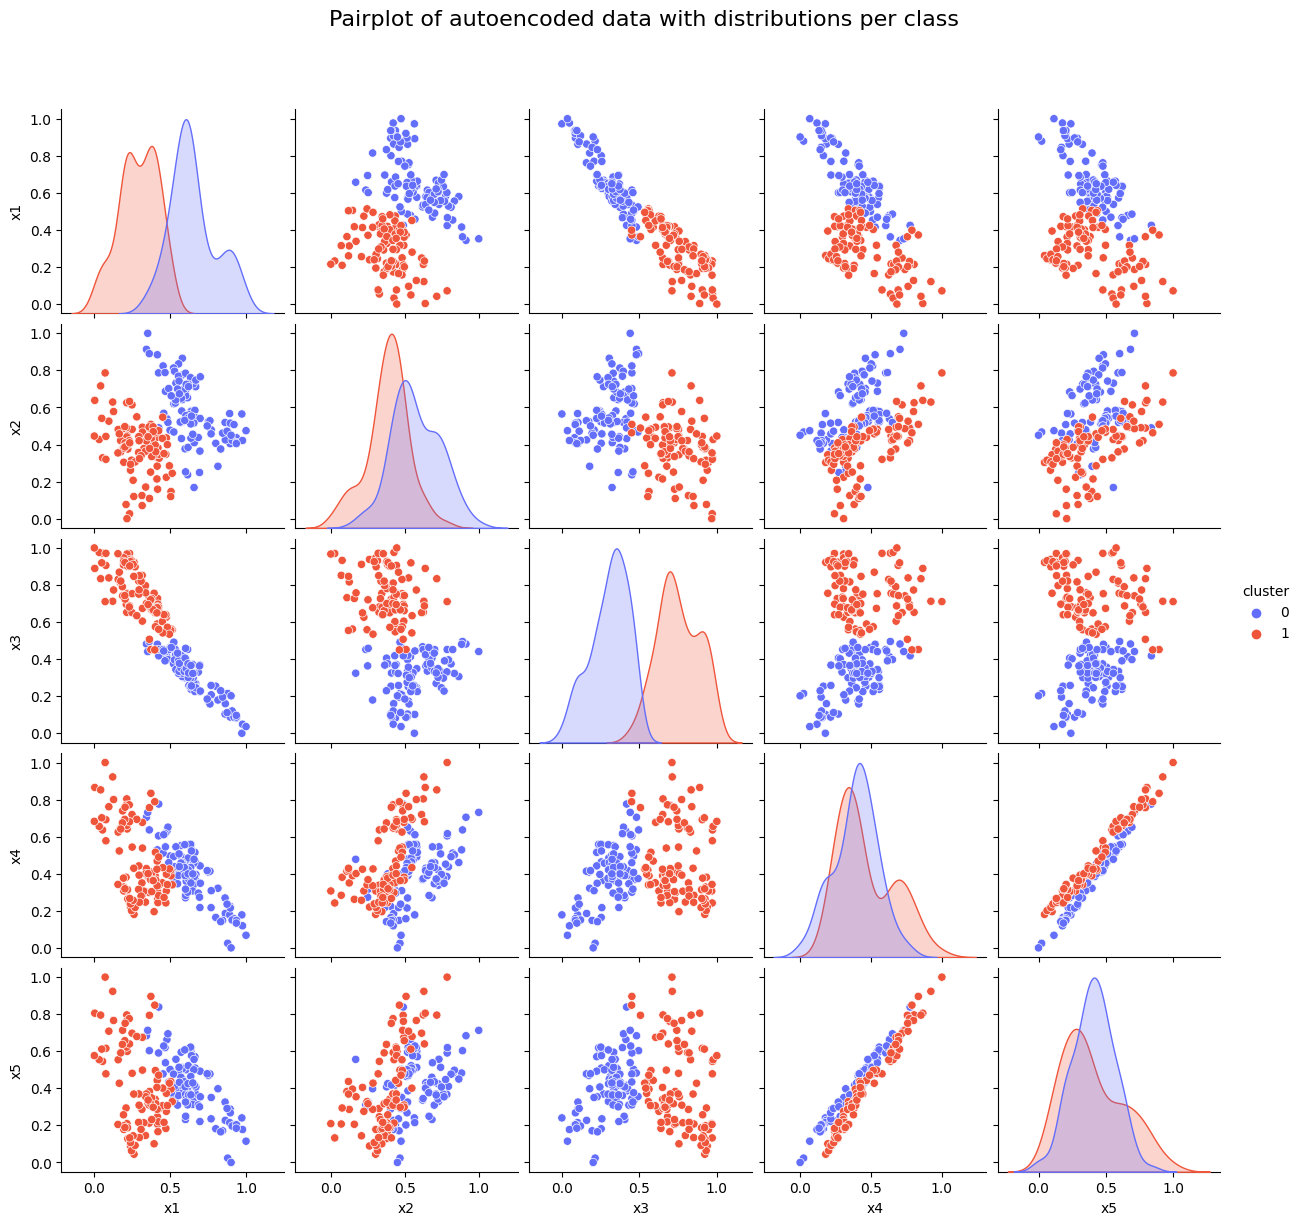

In [37]:
# Distribution of features
ax = sns.pairplot(data_autoencoded, hue="cluster");
ax.fig.suptitle("Pairplot of autoencoded data with distributions per class", size=16);
ax.figure.subplots_adjust(top=.9)

## Split data into train, validation and test

Because there are only 200 data observations, it would be wiser to split the data into train and test, and use the train set to fit (train) the model and also to perform cross-validation (https://scikit-learn.org/stable/modules/cross_validation.html).

In [38]:
# Set random seed for reproducibility
seed = 0
np.random.seed(seed)

In [39]:
# Split the data in 50:50 for train:test dataset
train_size = 0.5

X = data_autoencoded.drop(columns = ['cluster']).copy()
y = data_autoencoded['cluster']

# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=seed)

# Print resulting shapes
print(f"Train shape: features = {X_train.shape}, target = {y_train.shape}")
print(f"Test shape: features = {X_test.shape}, target = {y_test.shape}")

Train shape: features = (100, 5), target = (100,)
Test shape: features = (100, 5), target = (100,)


## Train models and compute training, average cross-validation and testing errors

### Train the models

In [40]:
# Instantiate the models
dt = DecisionTreeClassifier()
svm_linear = SVC(kernel = 'linear')
svm_poly = SVC(kernel = 'poly')
svm_rbf = SVC(kernel = 'rbf')
lr = LinearRegression()
logr = LogisticRegression()

In [41]:
# Store models in a list
models = [dt, svm_linear, svm_poly, svm_rbf, lr, logr]

In [42]:
# Variable to store results
results = []
for model in models:
  # Fit (train) the model with train data
  model.fit(X_train, y_train)

  # Create dictionary with results
  errors = {
      "training_error":1-model.score(X_train, y_train),
      "avg_crossvalidation_error":1-np.mean(cross_val_score(model, X_train, y_train, cv=5)),
      "testing_error":1-model.score(X_test, y_test),
  }

  # Print
  print(f"----------------{model}----------------")
  for key, value in errors.items():
    print(f"{key} = {value}")

  model_name = str(model)
  results.append({model_name:model, model_name+"_errors":errors})

----------------DecisionTreeClassifier()----------------
training_error = 0.0
avg_crossvalidation_error = 0.010000000000000009
testing_error = 0.010000000000000009
----------------SVC(kernel='linear')----------------
training_error = 0.010000000000000009
avg_crossvalidation_error = 0.019999999999999907
testing_error = 0.020000000000000018
----------------SVC(kernel='poly')----------------
training_error = 0.0
avg_crossvalidation_error = 0.0
testing_error = 0.0
----------------SVC()----------------
training_error = 0.0
avg_crossvalidation_error = 0.0
testing_error = 0.010000000000000009
----------------LinearRegression()----------------
training_error = 0.15928118847320594
avg_crossvalidation_error = 0.18158235873268525
testing_error = 0.18580761780537491
----------------LogisticRegression()----------------
training_error = 0.010000000000000009
avg_crossvalidation_error = 0.010000000000000009
testing_error = 0.020000000000000018


### Find the min number of samples to train the models

In [43]:
# Create empty dataframe with columns
pac_data_autoencoder = pd.DataFrame(columns = ["model", "vc", "n", "epsilon", "delta"])

# Possible values for epsilon and delta
epsilons = [0.1, 0.05, 0.01]
deltas = epsilons

# Number of required samples
for (model, (epsilon, delta)) in itertools.product(models,zip(epsilons, deltas)):
  vc = vc_dimension(model, X_train)
  n = get_required_samples(vc, epsilon=epsilon, delta=delta)
  pac_data_autoencoder = pac_data_autoencoder.append({"model":model, "vc":vc, "n":n,
                              "epsilon":epsilon, "delta":delta},
                             ignore_index=True)
  print(f"model = {model}, vc = {vc}, n = {n}")

model = DecisionTreeClassifier(), vc = 16.094379124341003, n = 184.0
model = DecisionTreeClassifier(), vc = 16.094379124341003, n = 382.0
model = DecisionTreeClassifier(), vc = 16.094379124341003, n = 2070.0
model = SVC(kernel='linear'), vc = 6, n = 84.0
model = SVC(kernel='linear'), vc = 6, n = 180.0
model = SVC(kernel='linear'), vc = 6, n = 1061.0
model = SVC(kernel='poly'), vc = 35, n = 374.0
model = SVC(kernel='poly'), vc = 35, n = 760.0
model = SVC(kernel='poly'), vc = 35, n = 3961.0
model = SVC(), vc = inf, n = inf
model = SVC(), vc = inf, n = inf
model = SVC(), vc = inf, n = inf
model = LinearRegression(), vc = 6, n = 84.0
model = LinearRegression(), vc = 6, n = 180.0
model = LinearRegression(), vc = 6, n = 1061.0
model = LogisticRegression(), vc = 6, n = 84.0
model = LogisticRegression(), vc = 6, n = 180.0
model = LogisticRegression(), vc = 6, n = 1061.0


In [44]:
pac_data_autoencoder

,model,vc,n,epsilon,delta
0,DecisionTreeClassifier(),16.094379,184.0,0.10,0.10
1,DecisionTreeClassifier(),16.094379,382.0,0.05,0.05
2,DecisionTreeClassifier(),16.094379,2070.0,0.01,0.01
3,SVC(kernel='linear'),6.000000,84.0,0.10,0.10
4,SVC(kernel='linear'),6.000000,180.0,0.05,0.05
5,SVC(kernel='linear'),6.000000,1061.0,0.01,0.01
6,SVC(kernel='poly'),35.000000,374.0,0.10,0.10
7,SVC(kernel='poly'),35.000000,760.0,0.05,0.05
8,SVC(kernel='poly'),35.000000,3961.0,0.01,0.01
9,SVC(),inf,inf,0.10,0.10
